In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal
import json
import sqlite3 as sql
import pywt
import pywt.data
from biosppy.signals import ecg
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
#with open("D:\data\ibeat\From laptops\Subject044_Device010\Results_20180523085043\sensor_test_results.json",'r') as load_f:
    #load_dict = json.load(load_f)
#load_dict

In [3]:
def hdf_to_dict(hdf_file):
    # Read all the keys in the file
    with pd.HDFStore(hdf_file, mode='r') as hdf:
        keys = hdf.keys()

    # Read all tables, store in dictionary
    data = {}
    for key in keys: data[key] = pd.read_hdf(hdf_file, key)
    return data

In [4]:
#a = hdf_to_dict('D:\data\ibeat\From laptops\Subject044_Device010\Subject044_Device010.BIN.hdf')
#a

In [5]:
raw_hdf = 'D:\data\ibeat\ibeat\Subject044\SE_GENERIC_DATA_EVENT_6671_001/Subject044_Device010_ibeatraw.hdf'
raw_data = hdf_to_dict(raw_hdf)

In [6]:
alg_hdf = 'D:\data\ibeat\ibeat\Subject044\SE_GENERIC_DATA_EVENT_6671_001/Subject044_Device010_ibeat_alg.hdf'
alg_data = hdf_to_dict(alg_hdf)

# Read and cut ECG data

In [7]:
ecg_data_file = 'D:\data\ibeat\eplab\Subject44_data.hdf'
ecg_data = pd.read_hdf(ecg_data_file, 'eplab')
ecg_data = ecg_data[(ecg_data['utc_adjusted']> 1527108380) & (ecg_data['utc_adjusted']<1527108473)]

In [8]:
## Run ECG Analysis on chunks:
ecg_chunks = []
print('Analyzing {} chunks'.format(len(ecg_data.section.unique())))
for section in ecg_data.section.unique():
    ecg_section = ecg_data[ecg_data.section == section]
    
    # Run biosppy ecg analysis
    ecg_analysis = ecg.ecg(signal=ecg_section.II, sampling_rate=976.942, show=False)
    
    ecg_chunks.append(pd.DataFrame(dict(ecg_heart_rate=ecg_analysis['heart_rate'], 
                                        utc=ecg_analysis['heart_rate_ts'] + ecg_section.utc_adjusted.iloc[0])))

# Concatinate results
ecg_analysis = pd.concat(ecg_chunks)

Analyzing 1 chunks


C:\Users\imapi\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\imapi\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\imapi\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index

# Wavelet transform  of ECG using pywt.dwt

Text(0.5, 1.0, 'Detail of ECG_db3')

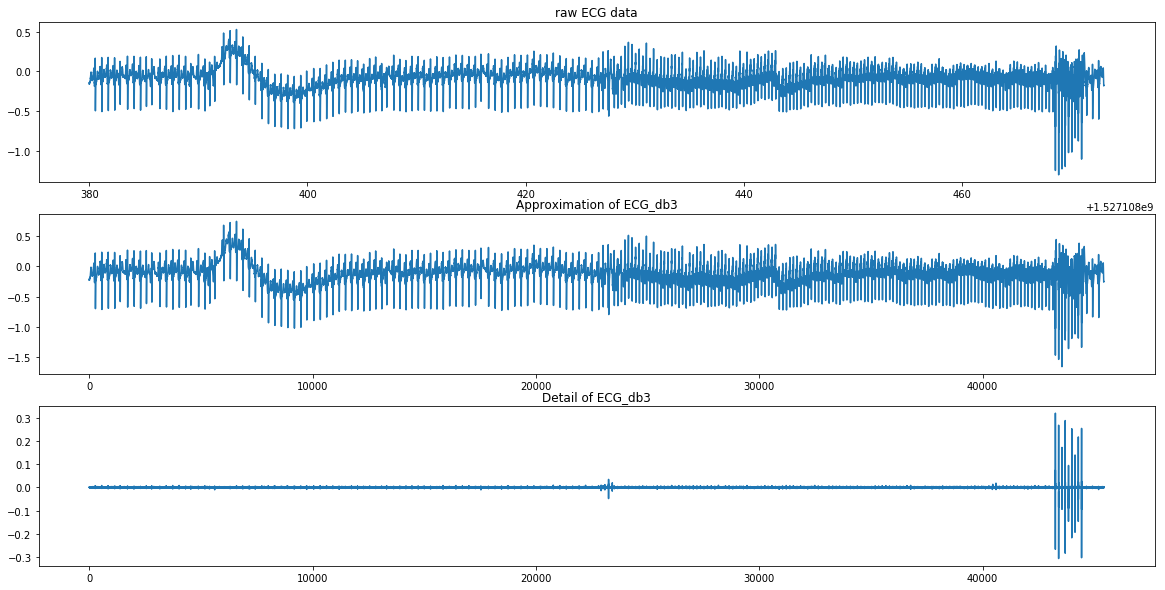

In [9]:

cA, cD = pywt.dwt(ecg_data.II, 'db3')

fig, ax = plt.subplots(3, 1, sharex=False, figsize=(20,10))

# Raw ECG Signal
ax[0].plot(ecg_data.utc_adjusted, ecg_data.II)

ax[1].plot(cA)

ax[2].plot(cD)

ax[0].set_title('raw ECG data')
ax[1].set_title('Approximation of ECG_db3')
ax[2].set_title('Detail of ECG_db3')

# WT of ppg signal

Text(0.5, 1.0, 'Detail of PPG_Haar')

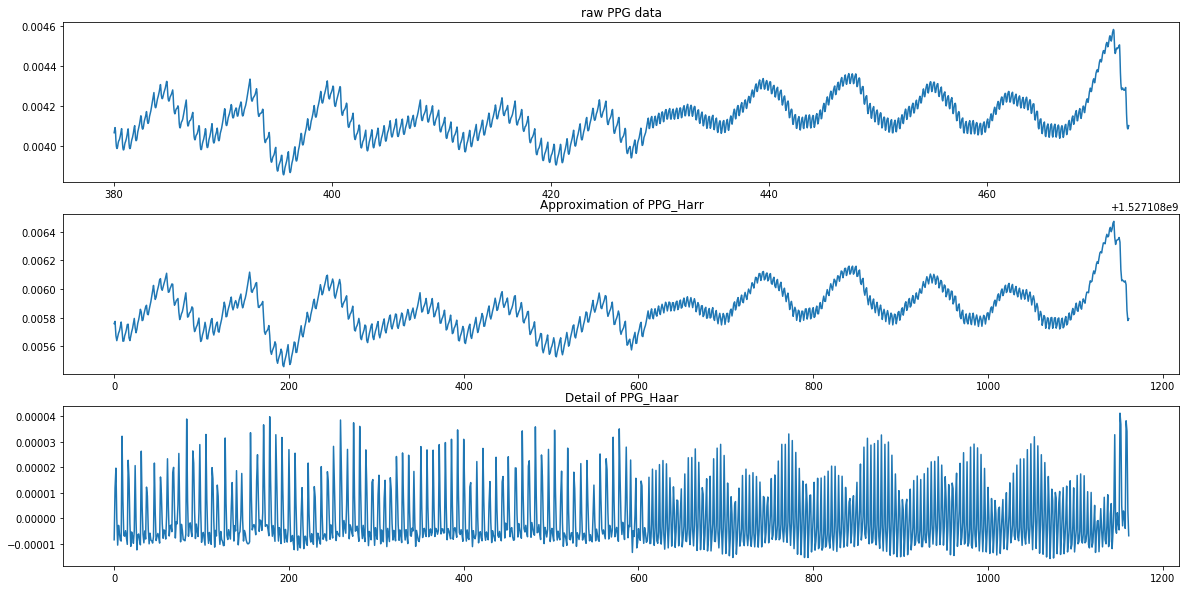

In [10]:
g_pkg1 = raw_data['/optical_streams/green/pkg1']
ppg_cut = g_pkg1[(g_pkg1['utc']> 1527108380) & (g_pkg1['utc']<1527108473)]

## Raw PPG signal - normalized by drive current and sensor gain
ppg_data = ppg_cut.pd1 / ppg_cut.drive_i / ppg_cut.gain_value

fig, ax = plt.subplots(3, 1, sharex=False, figsize=(20,10))

cA, cD = pywt.dwt(ppg_data, 'haar')

ax[0].plot(ppg_cut.utc, ppg_data)

ax[1].plot(cA)

ax[2].plot(cD)

ax[0].set_title('raw PPG data')
ax[1].set_title('Approximation of PPG_Harr')
ax[2].set_title('Detail of PPG_Haar')

Text(0.5, 1.0, 'Detail of PPG_db3')

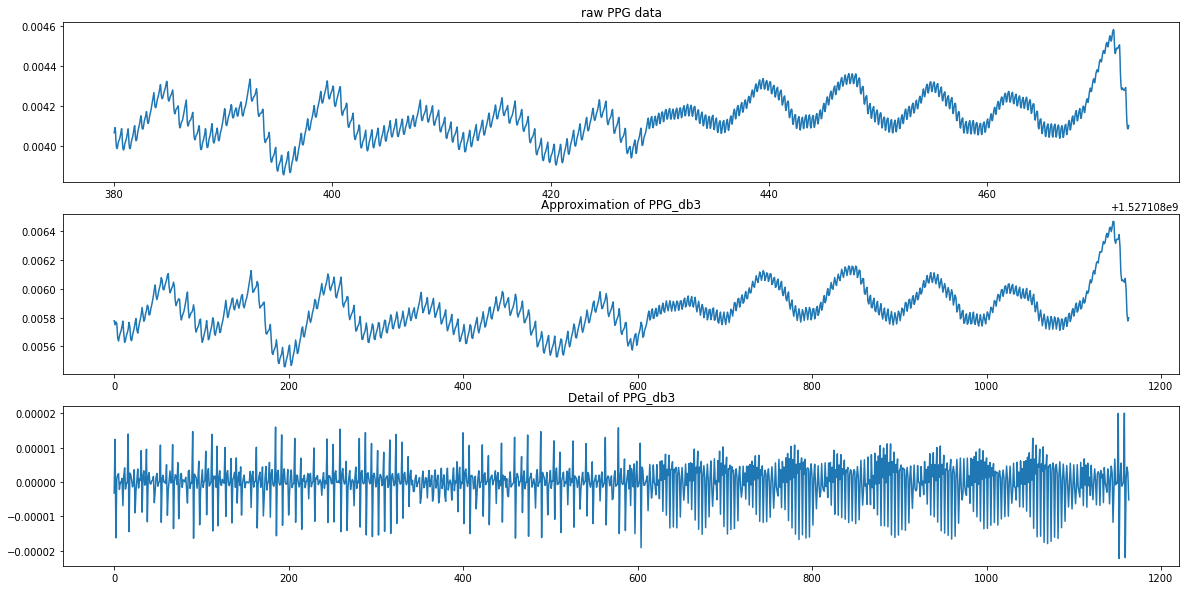

In [11]:
fig, ax = plt.subplots(3, 1, sharex=False, figsize=(20,10))

cA, cD = pywt.dwt(ppg_data, 'db3')

ax[0].plot(ppg_cut.utc, ppg_data)

ax[1].plot(cA)

ax[2].plot(cD)

ax[0].set_title('raw PPG data')
ax[1].set_title('Approximation of PPG_db3')
ax[2].set_title('Detail of PPG_db3')

In [12]:
cA, cD = pywt.dwt(ppg_data, 'symlet')

ValueError: Unknown wavelet name 'symlet', check wavelist() for the list of available builtin wavelets.

(-0.0002, 0.0002)

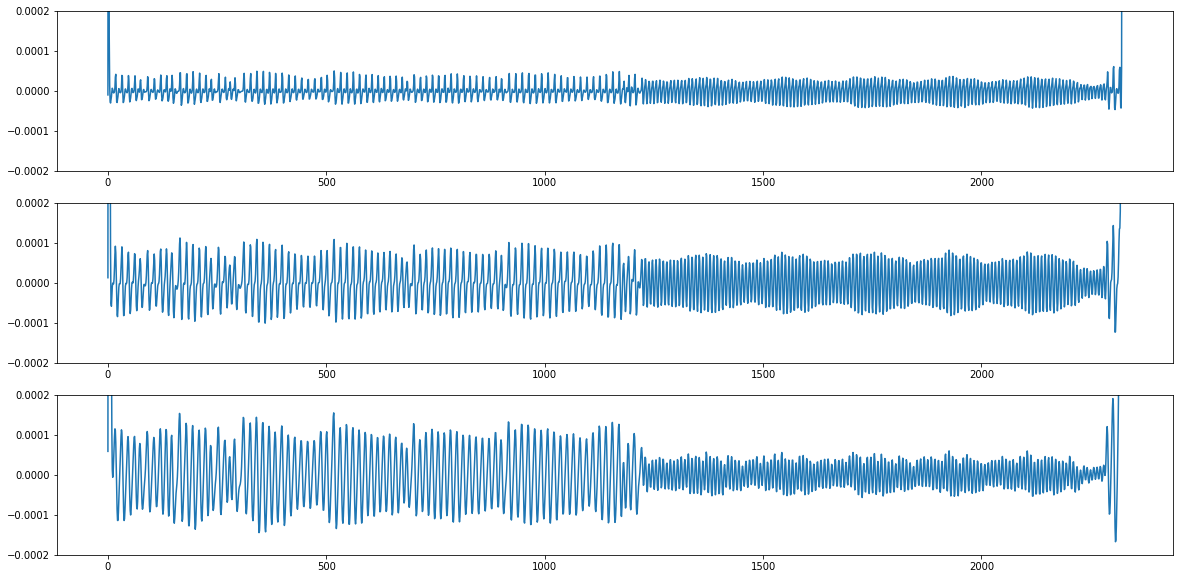

In [13]:
scale = np.arange(1,4)
#Ricker: Mexican hat
cwtmatr = signal.cwt(ppg_data, signal.ricker, scale)
#cwtmatr[0]
fig, ax = plt.subplots(3, 1, sharex=False,sharey=True,figsize=(20,10))

ax[0].plot(cwtmatr[0])
ax[1].plot(cwtmatr[1])
ax[2].plot(cwtmatr[2])
ax[0].set_ylim([- 0.0002, 0.0002])

Text(0.5, 1.0, 'heart rate analysis')

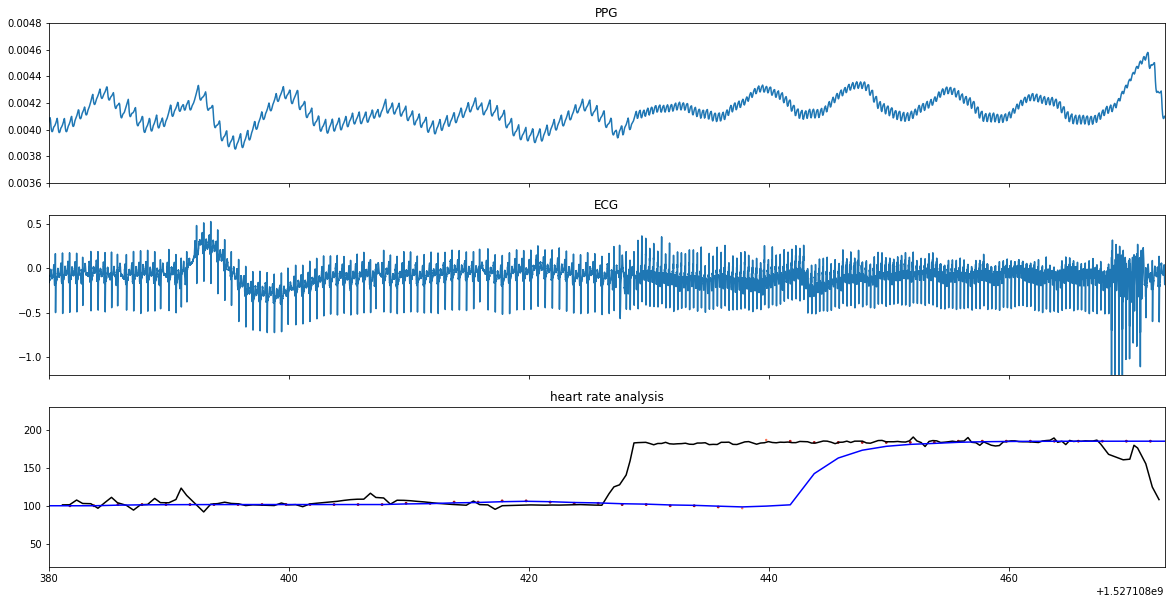

In [14]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(20,10))

# Raw PPG signal - normalized by drive current and sensor gain
g_pkg1 = raw_data['/optical_streams/green/pkg1']
ax[0].plot(g_pkg1.utc, g_pkg1.pd1 / g_pkg1.drive_i / g_pkg1.gain_value)

# Raw ECG Signal
ax[1].plot(ecg_data.utc_adjusted, ecg_data.II)

# PPG pulse rate and ecg heart rate
ax[2].plot(ecg_analysis.utc, ecg_analysis.ecg_heart_rate, c='k', label='ECG Heart Rate', )
ax[2].plot(alg_data['/pulse_rate_alg'].utc, alg_data['/pulse_rate_alg'].bpm_track, label='PPG Pulse Rate', c='b')

# Plot raw ppg bpm as points, scaled by confidence
ax[2].scatter(alg_data['/pulse_rate_alg'].utc, alg_data['/pulse_rate_alg'].bpm_raw, c=alg_data['/pulse_rate_alg'].bpm_conf, cmap='Reds', s=alg_data['/pulse_rate_alg'].bpm_conf * 20.0)

ax[0].set_xlim([1527108380, 1527108473])
ax[0].set_ylim([0.0036, 0.0048])
ax[1].set_ylim([-1.2, 0.6])
ax[0].set_title('PPG')
ax[1].set_title('ECG')
ax[2].set_title('heart rate analysis')

In [15]:
from scipy import signal
# High pass FIR filter function
def fir_highpass(x, cutoff, order):
    a = signal.firwin(order, cutoff=cutoff, window="hanning")
    # Spectral inversion
    a = -a
    a[int(order / 2)] = a[int(order / 2)] + 1
    return signal.filtfilt(a, [1], x)

C:\Users\imapi\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
C:\Users\imapi\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
C:\Users\imapi\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


Text(0.5, 1.0, 'Contact')

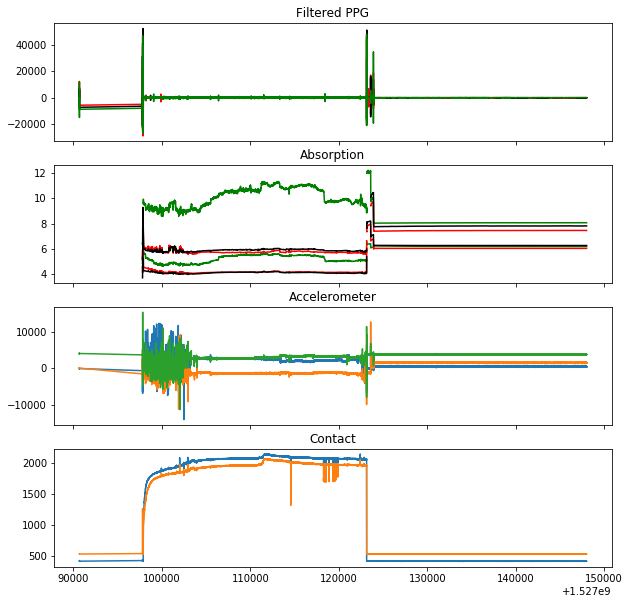

In [16]:
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(10, 10))


g_pkg1 = raw_data['/optical_streams/green/pkg1']
r_pkg1 = raw_data['/optical_streams/red/pkg1']
ir_pkg1 = raw_data['/optical_streams/ir/pkg1']

# Filtered PPG signals
ax[0].plot(r_pkg1.utc, fir_highpass(r_pkg1.pd1, 0.5 / (25.0 / 2), 101), 'r')
ax[0].plot(ir_pkg1.utc, fir_highpass(ir_pkg1.pd1, 0.5 / (25.0 / 2), 101), 'k')
ax[0].plot(g_pkg1.utc, fir_highpass(g_pkg1.pd1, 0.5 / (25.0 / 2), 101), 'g')
ax[0].set_title('Filtered PPG')

# Absorption signals
ax[1].plot(g_pkg1.utc, -np.log(g_pkg1.pd1/ g_pkg1.drive_i / g_pkg1.gain_value).rolling(25*15).mean(), 'g')
ax[1].plot(r_pkg1.utc, -np.log(r_pkg1.pd1/ r_pkg1.drive_i / r_pkg1.gain_value).rolling(25*15).mean(), 'r')
ax[1].plot(ir_pkg1.utc, -np.log(ir_pkg1.pd1/ ir_pkg1.drive_i / ir_pkg1.gain_value).rolling(25*15).mean(), 'k')


g_pkg2 = raw_data['/optical_streams/green/pkg2']
r_pkg2 = raw_data['/optical_streams/red/pkg2']
ir_pkg2 = raw_data['/optical_streams/ir/pkg2']
ax[1].plot(g_pkg2.utc, -np.log(g_pkg2.pd1/ g_pkg2.drive_i / g_pkg2.gain_value).rolling(50*15).mean(), 'g')
ax[1].plot(r_pkg2.utc, -np.log(r_pkg2.pd1/ r_pkg2.drive_i / r_pkg2.gain_value).rolling(25*15).mean(), 'r')
ax[1].plot(ir_pkg2.utc, -np.log(ir_pkg2.pd1/ ir_pkg2.drive_i / ir_pkg2.gain_value).rolling(25*15).mean(), 'k')
ax[1].set_title('Absorption')

# Accelerometer
accel = raw_data['/accel_data']
ax[2].plot(accel.utc, accel.x)
ax[2].plot(accel.utc, accel.y)
ax[2].plot(accel.utc, accel.z)
ax[2].set_title('Accelerometer')

# Contact data
contact = raw_data['/contact_data']
ax[3].plot(contact.utc, contact.pad1)
ax[3].plot(contact.utc, contact.pad2)
ax[3].set_title('Contact')

#ax[0].set_xlim([1524245000, 1524249500])
